In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [8]:
# Create a simple DFN model
model = pybamm.lithium_ion.DFN()
# create experiment
experiment = pybamm.Experiment(
    ["Rest for 901 s",
        (
            "Discharge at 0.96 A for 147 s",
            "Rest for 361 s",
        ) * 123,
     "Discharge at 0.96 A for 134 s"
    ]
    
)
# Setting the current function）
param = pybamm.ParameterValues("OKane2022")

# Creating Simulation Objects
solver = pybamm.CasadiSolver(mode="fast")
simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)

# Running simulations with time ranges consistent with data
solution = simulation.solve()  
# Getting results
time_sim = solution["Time [s]"].entries
# current = solution["Current [A]"].entries
voltage_sim = solution["Terminal voltage [V]"].entries

In [9]:
# Generate new time points, one data point per second, from 1 to 63519 seconds
time_new = np.arange(1, 63520, 1)
# Interpolation of simulated data to measured data point in time
interp_func = interp1d(time_sim, voltage_sim, kind='linear', fill_value='extrapolate')
voltage_sim_interp = interp_func(time_new)

In [10]:
# Load Measurement Data
real_data = pd.read_csv('data/data_ocv_ex.csv')
time_real = real_data['Testtime [s]'].values
voltage_real = real_data['Voltage[V]'].values

In [11]:
# Calculating MSE
mse = mean_squared_error(voltage_real, voltage_sim_interp)
print(f'MSE: {mse}')

MSE: 0.00125081644648287


In [12]:
# Save the interpolated data into the DataFrame
df_simulated = pd.DataFrame({
    "Testtime [s]": time_new,
    "Voltage[V]": voltage_sim_interp
})

# Saving a DataFrame as a CSV file
df_simulated.to_csv("data/data_ocv_sim_ex.csv", index=False)

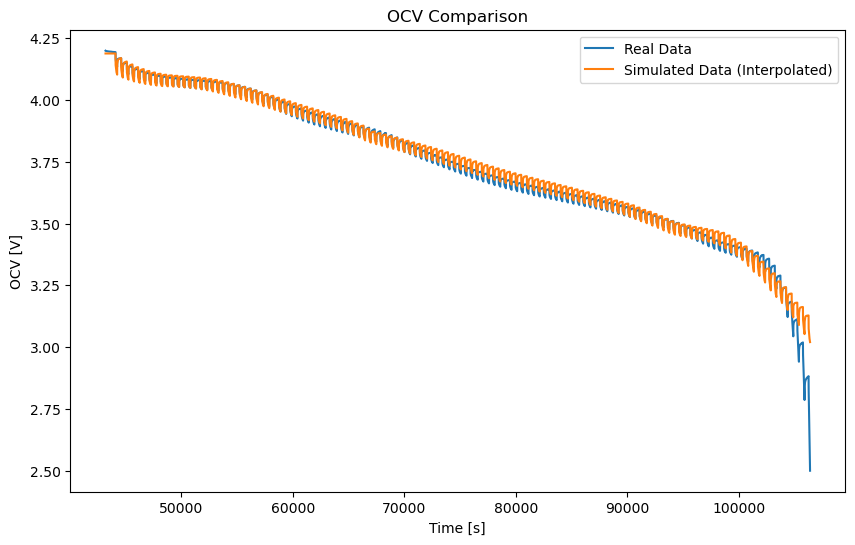

In [13]:
# Plotting comparisons
plt.figure(figsize=(10, 6))
plt.plot(time_real, voltage_real, label='Real Data')
plt.plot(time_real, voltage_sim_interp, label='Simulated Data (Interpolated)')
plt.xlabel('Time [s]')
plt.ylabel('OCV [V]')
plt.title('OCV Comparison')
plt.legend()
plt.show()